In [1]:
'''
Use of flowers dataset,
input pipeline from directory
image data generator to create input batches
transfer learning with feature extractor
'''

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
DATASET_PATH = '/Users/atulpc/Desktop/New folder/Study/flower_photos'
TRAIN_PATH = os.path.join(DATASET_PATH,'training_set')
VAL_PATH = os.path.join(DATASET_PATH,'validation_set')

In [4]:
try:
    classes = sorted(os.walk(DATASET_PATH).next()[1])
except:
    classes = sorted(os.walk(DATASET_PATH).__next__()[1])
print(classes)
for c in classes:
    class_dir = os.path.join(DATASET_PATH,c)
    images = glob.glob(class_dir+'/*.jpg')
    train, validation = images[:round(len(images)*.7)], images[round(len(images)*.7):]
    for t in train:
        if not os.path.exists(os.path.join(DATASET_PATH,'training_set',c)):
            os.makedirs(os.path.join(DATASET_PATH,'training_set',c))
        shutil.move(t,os.path.join(TRAIN_PATH,c))
    for v in validation:
        if not os.path.exists(os.path.join(DATASET_PATH,'validation_set',c)):
            os.makedirs(os.path.join(DATASET_PATH,'validation_set',c))
        shutil.move(v,os.path.join(DATASET_PATH,'validation_set',c))

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
imagest = glob.glob(TRAIN_PATH+'/*/*.jpg')
imagesv = glob.glob(VAL_PATH+'/*/*.jpg')
total_train = len(imagest)
total_val = len(imagesv)
print(total_train, total_val)

2569 1101


In [6]:
IMG_SIZE=224
N_CLASSES = 5
CHANNELS = 3
BATCH_SIZE = 32

In [7]:
train_image_generator =ImageDataGenerator(rescale=1./255,)
train_data = train_image_generator.flow_from_directory(batch_size= BATCH_SIZE,
                                                          directory=TRAIN_PATH,
                                                          shuffle=True,
                                                          target_size=(IMG_SIZE,IMG_SIZE), 
                                                       class_mode = 'sparse'
                                                      )
for image_batch, label_batch in train_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Found 2569 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32,)


In [8]:
validation_batch = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=VAL_PATH,
                                                           target_size=(IMG_SIZE,IMG_SIZE),
                                                             class_mode = 'sparse'
                                                           )
for image_batch, label_batch in validation_batch:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Found 1101 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32,)


In [9]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(feature_extractor_url,input_shape=(IMG_SIZE,IMG_SIZE,3))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [10]:
feature_extractor.trainable = False
model = tf.keras.Sequential([feature_extractor,
                            layers.Dense(N_CLASSES, activation='softmax')
                            ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy']
             )
EPOCHS = 6
history = model.fit(train_data,
                   epochs = EPOCHS,
                    verbose = 2,
                   validation_data = validation_batch)

Train for 81 steps, validate for 35 steps
Epoch 1/6
81/81 - 38s - loss: 0.7836 - accuracy: 0.7135 - val_loss: 0.5214 - val_accuracy: 0.8211
Epoch 2/6
81/81 - 26s - loss: 0.3803 - accuracy: 0.8731 - val_loss: 0.4247 - val_accuracy: 0.8520
Epoch 3/6
81/81 - 27s - loss: 0.2917 - accuracy: 0.9027 - val_loss: 0.3826 - val_accuracy: 0.8574
Epoch 4/6
81/81 - 27s - loss: 0.2434 - accuracy: 0.9241 - val_loss: 0.3678 - val_accuracy: 0.8665
Epoch 5/6
81/81 - 28s - loss: 0.2082 - accuracy: 0.9366 - val_loss: 0.3663 - val_accuracy: 0.8792
Epoch 6/6
81/81 - 27s - loss: 0.1795 - accuracy: 0.9463 - val_loss: 0.3508 - val_accuracy: 0.8792


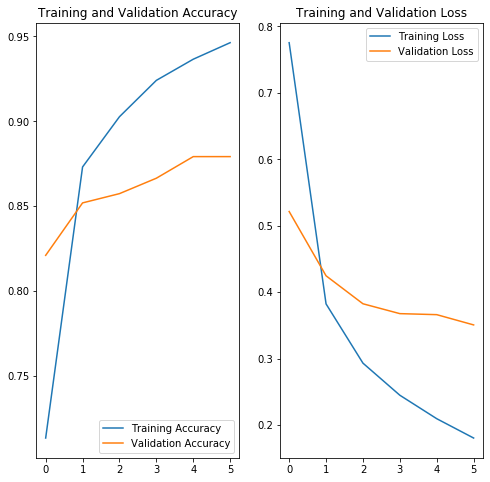

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
class_names = np.array(classes)
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [14]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['daisy', 'dandelion', 'daisy', 'daisy', 'dandelion', 'roses',
       'tulips', 'dandelion', 'sunflowers', 'dandelion', 'dandelion',
       'daisy', 'daisy', 'dandelion', 'dandelion', 'sunflowers',
       'dandelion', 'daisy', 'tulips', 'tulips', 'tulips', 'daisy',
       'daisy', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'daisy',
       'dandelion', 'roses', 'daisy', 'tulips'], dtype='<U10')

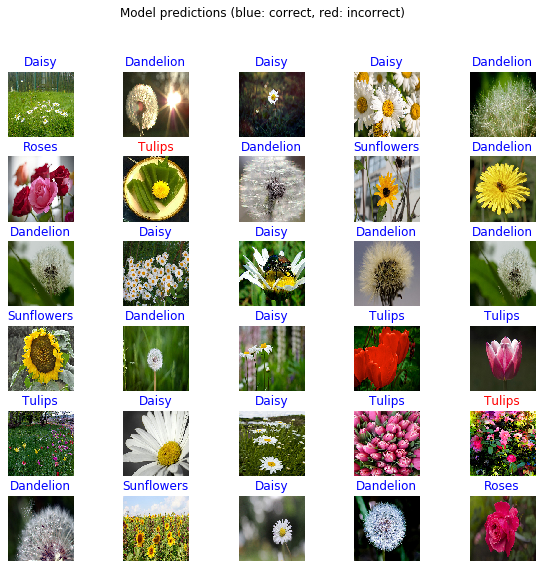

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
import time
t = time.time()

In [ ]:
!pip install -q pyyaml h5py


In [19]:
#path = './'
#tf.keras.models.save_model('my_secondmodel.h5', path)
tf.keras.experimental.export_saved_model(model, 'path_to_my_model.h5')

In [20]:
reloaded = tf.keras.experimental.load_from_saved_model('path_to_my_model.h5',
                                    custom_objects={'KerasLayer': hub.KerasLayer})
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [22]:
(abs(result_batch - reloaded_result_batch)).max()

0.0